<a href="https://colab.research.google.com/github/SourLemon23/covid19-diagnosis/blob/master/Grad-CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install vis
! pip install keras==2.2.2
! pip install tensorflow==1.10.0
! pip install scipy==1.1.0


     |████████████████████████████████| 307kB 8.5MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
ERROR: tensorflow 2.3.0 has requirement keras-preprocessing<1.2,>=1.1.1, but you'll have keras-preprocessing 1.0.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: efficientnet 1.1.1 has requirement keras-applications<=1.0.8,>=1.0.7, but you'll have keras-applications 1.0.4 which is incompatible.
  Found existing installation: Keras-Preprocessing 1.1.2
    Uninstalling Keras-Preprocessing-1.1.2:
      Successfully uninstalled Keras-Preprocessing-1.1.2
  Found existing installation: Keras-Applications 1.0.8
    Uninstalling Keras-Applications-1.0.8:
      Successfully uninstalled Keras-Applications-1.0.8
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


     |████████████████████████████████| 58.4MB 50kB/s 
     |████████████████████████████████| 12.2MB 18.1MB/s 
     |████████████████████████████████| 573kB 53.3MB/s 
     |████████████████████████████████| 3.3MB 54.9MB/s 
ERROR: xarray 0.15.1 has requirement numpy>=1.15, but you'll have numpy 1.14.5 which is incompatible.
ERROR: xarray 0.15.1 has requirement setuptools>=41.2, but you'll have setuptools 39.1.0 which is incompatible.
ERROR: umap-learn 0.4.6 has requirement numpy>=1.17, but you'll have numpy 1.14.5 which is incompatible.
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: tifffile 2020.9.3 has requirement numpy>=1.15.1, but you'll have numpy 1.14.5 which is incompatible.
ERROR: spacy 2.2.4 has requirement numpy>=1.15.0, but you'll have numpy 1.14.5 which is incompatible.
ERROR: seaborn 0.11.0 has requirement numpy>=1.15, but you'll have numpy 1.14.5 which is incompatible.
ERROR: plotnine 0.6.0 has requirement n

In [ ]:




import os
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt

# EfficientNetB7
# ! pip install efficientnet
from efficientnet.tfkeras import EfficientNetB7

# Grad-CAM
import scipy
print(scipy.__version__) # 1.1.0



1.1.0


In [ ]:

import vis
from vis.utils import utils
from vis.visualization import visualize_cam

ImportError: ignored

In [ ]:
# Authorize access to mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Initialize dataset directories (Google Drive)
ct_training_dir   = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset - Copy/Training'
ct_validation_dir = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset - Copy/Validation'
ct_testing_dir    = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset - Copy/Testing'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# # Store all testing images in a list
# testing_img_paths = []

# for root, dirs, files in os.walk(testing_dir):
#     for filename in files:
#         testing_img_paths.append(os.path.abspath(os.path.join(root, filename)))

# # Randomize the list
# random.shuffle(testing_img_paths)

In [ ]:
# Initialize constants
classes = ['Test Positive for COVID-19', 'Test Negative for COVID-19']
img_width, img_height = 150, 150
target_size = (img_width, img_height)
input_shape = (img_width, img_height, 3)

testing_set_start_index = -50
testing_set_end_index = 49

batch_size = 30
epochs = 3

In [ ]:
# Augment data
training_data_gen = ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       zoom_range=0.15,
                                       shear_range=0.15,
                                       rotation_range=360,
                                       width_shift_range=0.15,
                                       height_shift_range=0.15,
                                       validation_split=0.15)

validation_data_gen = ImageDataGenerator(rescale=1./255)

testing_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Split data
training_generator = training_data_gen.flow_from_directory(ct_training_dir,
                                                           target_size=target_size,
                                                           class_mode='categorical',
                                                           batch_size=batch_size,
                                                           shuffle=True)

#  SHUFFLE = TRUE??
validation_generator = validation_data_gen.flow_from_directory(ct_validation_dir,
                                                               target_size=target_size,
                                                               class_mode='categorical',
                                                               batch_size=batch_size,
                                                               shuffle=False)

testing_generator = testing_data_gen.flow_from_directory(ct_testing_dir,
                                                         target_size = target_size,
                                                         class_mode='categorical',
                                                         batch_size=batch_size,
                                                         shuffle=True)

Found 4015 images belonging to 2 classes.
Found 348 images belonging to 2 classes.
Found 390 images belonging to 2 classes.


In [ ]:
# Create a neural network
def create_model():
    model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
    
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    predictions = Dense(training_generator.num_classes, activation="softmax")(x)
    model = Model(inputs=model.input, outputs=predictions)

    return model

In [ ]:
# Print an overall summary of the model
def print_model_summary(model):
    model.summary()

In [ ]:
# Configure model
def compile_model(model):
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
# Train the model
def fit_model(model):
    history = model.fit(training_generator,
                        epochs=epochs,
                        steps_per_epoch=(training_generator.n/batch_size),
                        validation_data=validation_generator,
                        validation_steps=(validation_generator.n/batch_size))
    
    return history

In [ ]:
# Plot and evaluate the model
def evaluate_model(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

In [ ]:
# Randomly pick and display an unseen image for the network to predict
def select_testing_image():
    image_num = random.randint(testing_set_start_index, testing_set_end_index)
    testing_img = testing_generator[0][0][image_num]

    class_num = np.argmax(testing_generator[0][1][image_num])
    true_label = classes[class_num].capitalize()

    print(f'True Label: {true_label}')

    return testing_img

In [ ]:
# Run a diagnosis to determine if the patient is positive or negative for COVID-19
def run_diagnosis(model, testing_img):      
    img_array = img_to_array(testing_img)
    img_array = img_array.reshape(-1, img_width, img_height, 3)

    predictions = model.predict(img_array)
    class_num = predictions.argmax()

    network_percent_confidence = str(np.max(predictions) * 100)[:4] + '% match'
    network_prediction = classes[class_num].capitalize()

    font = {'family': 'DejaVu Sans',
            'color' : 'red',
            'weight': 'heavy',
            'size'  :  10}
    
    plt.imshow(testing_img)
    # Find a way to only make the text after "Network Prediction" red
    plt.title(f'Network Prediction: {network_prediction} ({network_percent_confidence})', fontdict=font) 

In [ ]:
model = create_model()
compile_model(model)
print_model_summary(model)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 75, 75, 64)   1728        input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 75, 75, 64)   256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 75, 75, 64)   0           stem_bn[0][0]                    
_______________________________________________________________________________________

Epoch 1/3
134/133 [==============================] - 114s 854ms/step - loss: 0.1096 - accuracy: 0.9664 - val_loss: 1.8990 - val_accuracy: 0.5144
Epoch 2/3
134/133 [==============================] - 115s 855ms/step - loss: 0.0156 - accuracy: 0.9940 - val_loss: 4.2305 - val_accuracy: 0.6149
Epoch 3/3
134/133 [==============================] - 115s 858ms/step - loss: 0.0081 - accuracy: 0.9978 - val_loss: 3.1828 - val_accuracy: 0.6466


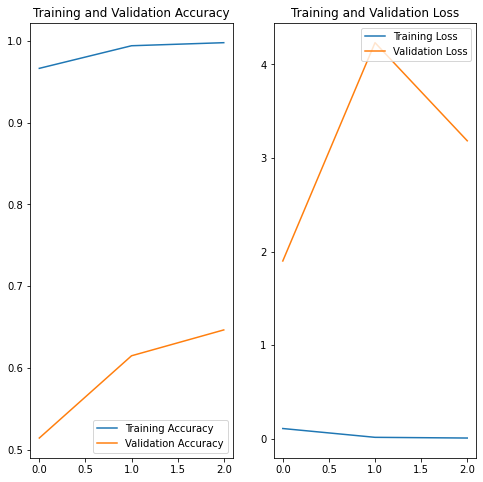

In [ ]:
history = fit_model(model)
evaluate_model(history)

In [ ]:
classifier_layer_names = ['top_conv', 'top_bn', 'top_activation', 'global_average_pooling2d_1', 'dropout_1', 'dense_3', 'dense_4', 'dense_5']
last_conv_layer_name = 'block7d_add'

def convert_to_img_array(img_path):
    # img is a PIL image
    img = load_img(img_path,
                   target_size=target_size)
    
    # Convert to float32 Numpy array
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    # img_array = img_array.reshape((-1, img_width, img_height, 3))

    # We add a dimension to transform our array into a "batch"
    # img_array = np.expand_dims(img_array, axis=0)

    return img_array

In [ ]:
classifier_layer_names = ['top_conv', 'top_bn', 'top_activation', 'global_average_pooling2d_1', 'dropout_1', 'dense_3', 'dense_4', 'dense_5']
last_conv_layer_name = 'block7d_add'

img_path = f'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_xray_dataset/Testing/covid19/Github COVID-19 X-ray Dataset/000001-1.jpg'

img = load_img(img_path,
               target_size=target_size)

img               = img_to_array(img)
# img               = preprocess_input(img)
y_pred            = model.predict(img[np.newaxis,...])
class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
# topNclass         = 5
# for i, idx in enumerate(class_idxs_sorted[:topNclass]):
#     print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
#           i + 1,classlabel[idx],idx,y_pred[0,idx]))

# Utility to search for layer index by name. 
# ***********  Alternatively we can specify this as -1 since it corresponds to the last layer.  ***************
layer_idx = utils.find_layer_idx(model, 'dense_8')
# Swap softmax with linear
model.layers[layer_idx].activation = tf.keras.activations.linear
model = utils.apply_modifications(model)

penultimate_layer_idx = utils.find_layer_idx(model, "top_conv") 
class_idx  = class_idxs_sorted[0]
seed_input = img
grad_top1  = visualize_cam(model, layer_idx, class_idx, seed_input, 
                           penultimate_layer_idx = penultimate_layer_idx) # TRY TO LEAVE BLANK? -> OR AS 'none'?
                          #  backprop_modifier     = None)
                          #  grad_modifier         = None)

RuntimeError: ignored

In [ ]:
print(scipy.__version__)

In [ ]:
def plot_map(grads):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(_img)
    axes[1].imshow(_img)
    i = axes[1].imshow(grads,cmap="jet", alpha=0.8)
    fig.colorbar(i)
    plt.suptitle("Pr(class={}) = {:5.2f}".format(
                      classlabel[class_idx],
                      y_pred[0,class_idx]))

In [ ]:
img_path = f'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_xray_dataset/Testing/covid19/Github COVID-19 X-ray Dataset/000001-1.jpg'
plot_map(grad_top1)

# testing_img = select_testing_image()
# run_diagnosis(model, testing_img)